# Advanced Lane Finding Project

The goals / steps of this project  is to architect a pipline which accomplishes the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Required Libraries

In [331]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib qt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Project Constant Settings

In [414]:
CAMERA_CALIBRATION_IMAGES_FOLDER = 'camera_cal'

### Helper Functions

In [494]:
def show_save_before_after(before_image,after_image,before_title,after_title,fig_save_name):
    """
    The purpose of this function is display and save the image of the effect of before and after a 
    specific step in the pipeline.
    """
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    x = fig.add_subplot(1,2,1)
    x.set_title(before_title,size=20)
    x.imshow(before_image)
    
    
    y = fig.add_subplot(1,2,2)
    y.set_title(after_title,size =20)
    y.imshow(after_image)
  
    
    plt.show()
    fig.savefig(fig_save_name)
    

def cvt_fig_to_img(fig):
    """
    The goal of this function is to convert a figure into an image that can be then saved.
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring (fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

### Step -1 Camera Calibration and Distortion Correction

The first step of the pipeline is to compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

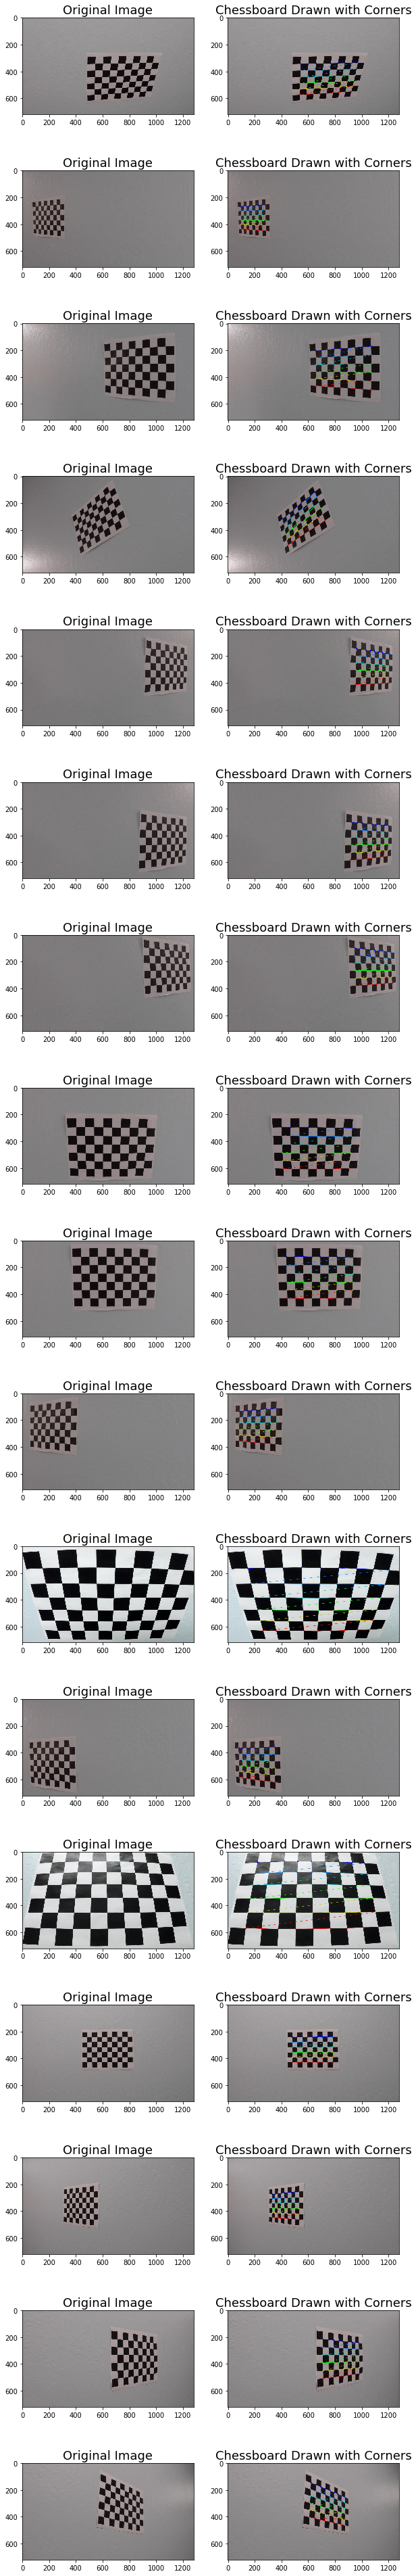

In [498]:
def calibrate_camera(calibration_folder=None,show_image=True):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calibration_folder+'/calibration*.jpg')
    if show_image:
        fig=plt.figure(figsize=(10,70))
    num = 1
    gray = None 
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_cp = np.copy(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            if show_image:
                draw_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                y = fig.add_subplot(17,2,num)
                y.set_title("Original Image",size=18)
                y.imshow(img_cp)
                
                num+=1
                
                x = fig.add_subplot(17,2,num)
                x.set_title("Chessboard Drawn with Corners",size=18)
                x.imshow(draw_img)
            num+=1
    if show_image:        
        plt.show()
        fig.savefig("reference_images/finding-corners-images")
    
    return objpoints,imgpoints

objpoints,imgpoints = calibrate_camera(CAMERA_CALIBRATION_IMAGES_FOLDER,show_image=True)

In [418]:
image = mpimg.imread('test_images/test2.jpg')
img_size = (image.shape[1],image.shape[0])
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,
                                               imgpoints,
                                               img_size,
                                               None,
                                               None)

### Step - 2  Undistort Image

The next step of the pipeline uses the distortion coefficients and camera calibrations computed in the previous step to remove any distortion from the image and returns the undistorted image as a result.

In [419]:
def undistort_image(img,mtx,dist):
    """
    img: image to undistort
    mtx: Camera matrix
    dist: distortion coefficient
    """
    return cv2.undistort(img,mtx,dist,None,mtx)

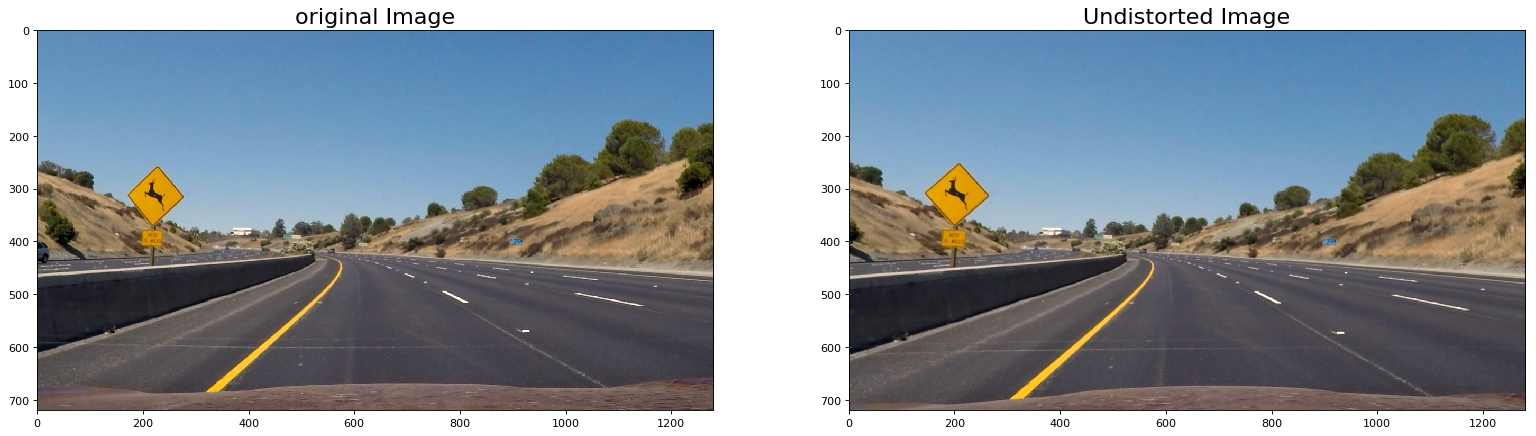

In [431]:
undist = undistort_image(image,mtx,dist)
show_save_before_after(image,undist,"original Image","Undistorted Image","reference_images/undistort-images")


### Step -3 Perspective Transform (Bird's-Eye View)
This step involves transforming the undistorted image returned from the prvious step of the pipeline to a "birds eye view" perspective of the road which focuses only on the lane lines and makes the lane lines appear to be relatively parallel to one another as opposed to appearing to be converging with one another. The advantage of this is that it would help make it easier to fit polynomials to the lane lines and measure the curvature in the later steps ofthe pipeline.

In [434]:
def perspective_transform(img):
    """
    img: Source image
    src: Source points
    dst: Destination points
    """
    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,Minv

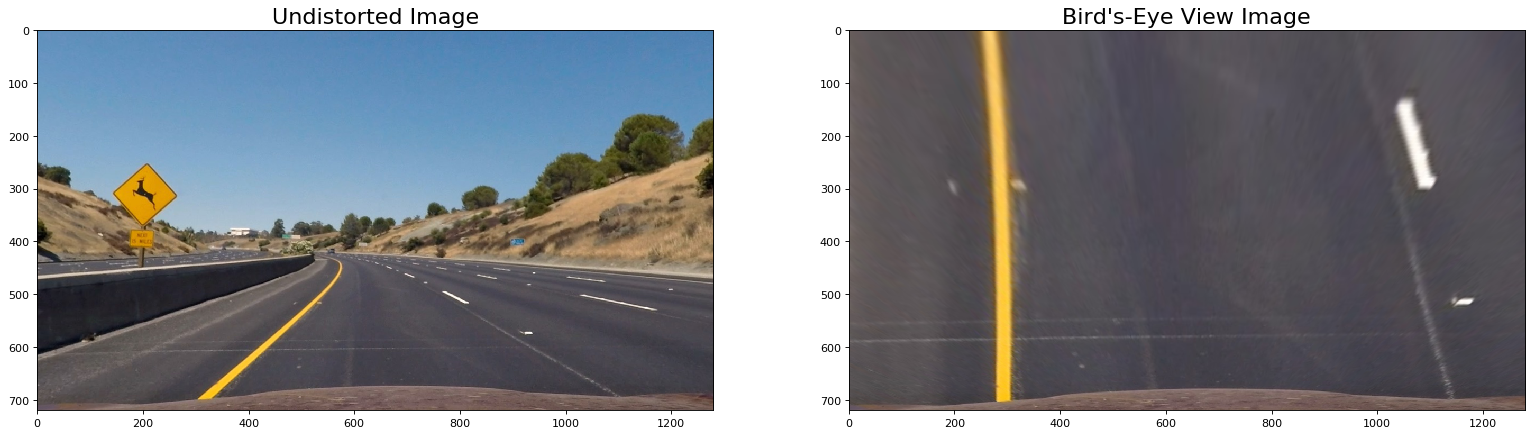

In [435]:
warped,Minv = perspective_transform(undist)
show_save_before_after(undist,warped,"Undistorted Image","Bird's-Eye View Image","reference_images/birds-eye-view-image")

### Step - 4 Apply Binary Thresholds to Images

This step of the pipeline involves converting the warped image of the road to different color spaces and create binary thresholded which elicits only the lane lines on the road and igonores everything else. 

In [504]:
def sobel(img=None,to_gray=False,sobel_kernel=3,x=None,y=None,thresh =(0,255)):
    img = np.copy(img)
    if to_gray:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(img,cv2.CV_64F,x,y,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(img=None,to_gray=False,sobel_kernel=3,mag_thresh=(0,255)):
    img = np.copy(img)
    if to_gray:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    gradient_magnitude = np.sqrt(sobelx**2+sobely**2)
    scaled_factor = np.max(gradient_magnitude)/255
    gradient_magnitude = (gradient_magnitude/scaled_factor).astype(np.uint8)
    binary_output =np.zeros_like(gradient_magnitude)
    binary_output[(gradient_magnitude >= mag_thresh[0]) & (gradient_magnitude <= mag_thresh[1])] =1
    return binary_output
    
def dir_thresh(img=None,to_gray=False,sobel_kernel=3,thresh=(0,np.pi/2)):
    img = np.copy(img)
    if to_gray:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    absgraddir = np.arctan(np.absolute(sobely)/np.absolute(sobelx))
    binary_output=np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] =1
    return binary_output

def combine_thresh(img,to_gray=False,sobel_kernel=3):
    gradx = sobel(img,to_gray,sobel_kernel,1,0,(20,100))
    grady = sobel(img,to_gray,sobel_kernel,0,1,(20,100))
    mag_binary = mag_thresh(img,to_gray,sobel_kernel,(30,100))
    dir_binary = dir_thresh(img,to_gray,sobel_kernel=15,thresh=(0.7,1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    
def seperate_color_channel(img,channel):
    if channel == 'r':
        return img[:,:,0]
    elif channel == 'g':
        return img[:,:,1]
    else:
        return img[:,:,2]
    
def seperate_hls_color_channel(img,channel):
    img_cvt = np.copy(img)
    img_cvt = cv2.cvtColor(img_cvt,cv2.COLOR_RGB2HLS)
    if channel == 'h':
        return img_cvt[:,:,0]
    elif channel == 'l':
        return img_cvt[:,:,1]
    elif channel == 's':
        return img_cvt[:,:,2]
    else:
        return img_cvt
    
def seperate_hsv_color_channel(img,channel):
    img_cvt = np.copy(img)
    img_cvt = cv2.cvtColor(img_cvt,cv2.COLOR_RGB2HSV)
    if channel == 'h':
        return img_cvt[:,:,0]
    elif channel == 's':
        return img_cvt[:,:,1]
    elif channel =='v':
        return img_cvt[:,:,2]
    else:
        return img_cvt

def seperate_luv_color_channel(img,channel):
    img_cvt = np.copy(img)
    img_cvt = cv2.cvtColor(img_cvt,cv2.COLOR_RGB2LUV)
    if channel == 'l':
        return img_cvt[:,:,0]
    elif channel == 'u':
        return img_cvt[:,:,1]
    elif channel =='v':
        return img_cvt[:,:,2]
    else:
        return img_cvt
    
def seperate_lab_color_channel(img,channel):
    img_cvt = np.copy(img)
    img_cvt = cv2.cvtColor(img_cvt,cv2.COLOR_RGB2Lab)
    if channel == 'l':
        return img_cvt[:,:,0]
    elif channel == 'a':
        return img_cvt[:,:,1]
    elif channel =='b':
        return img_cvt[:,:,2]
    else:
        return img_cvt
   
def color_thresh(img,thresh=(200,255)):
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary

def combine_color_thresh(img):
    r = color_thresh(seperate_color_channel(img,'r'),(200,255))
    s = color_thresh(seperate_hls_color_channel(img,'s'),(90,255))
    binary_output = np.zeros_like(r)
    binary_output[(r == 1) | (s ==1)] = 1
    return binary_output

def combine_thresh(img):
    r = color_thresh(seperate_color_channel(img,'r'),(200,255))
    s_binary = color_thresh(seperate_hls_color_channel(img,'s'),(90,255))
    l_binary = color_thresh(seperate_luv_color_channel(img,'l'),(215,255))
    b_binary = color_thresh(seperate_lab_color_channel(img,'b'),(145,200))    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary ==1) |(b_binary==1) | (r == 1) | (s_binary ==1)]=1
    return combined_binary


### Test Sobel

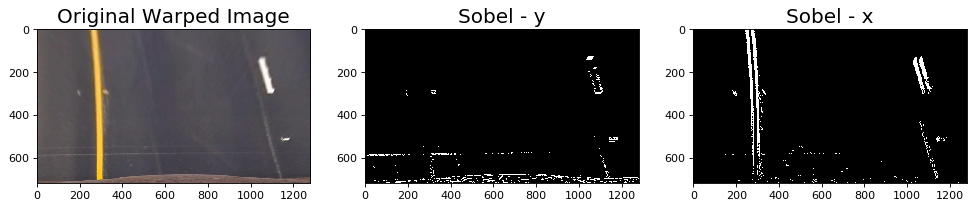

In [447]:
fig=plt.figure(figsize=(15, 35), dpi= 80, facecolor='w', edgecolor='k')

x = fig.add_subplot(1,3,1)
x.set_title("Original Warped Image",size=18)
x.imshow(warped)
    

sobely = sobel(warped,to_gray=True,sobel_kernel=3,x=0,y=1,thresh=(20,100))

y = fig.add_subplot(1,3,2)
y.set_title("Sobel - y",size=18)
y.imshow(sobely, cmap='gray')

z = fig.add_subplot(1,3,3)
sobelx = sobel(warped,to_gray=True,sobel_kernel=3,x=1,y=0,thresh=(20,100))
z.set_title("Sobel - x",size=18)
z.imshow(sobelx,cmap='gray')

plt.show()
fig.savefig("reference_images/test-sobel-images")  

### Test Color,  Gradient and Combined Binary Threshold

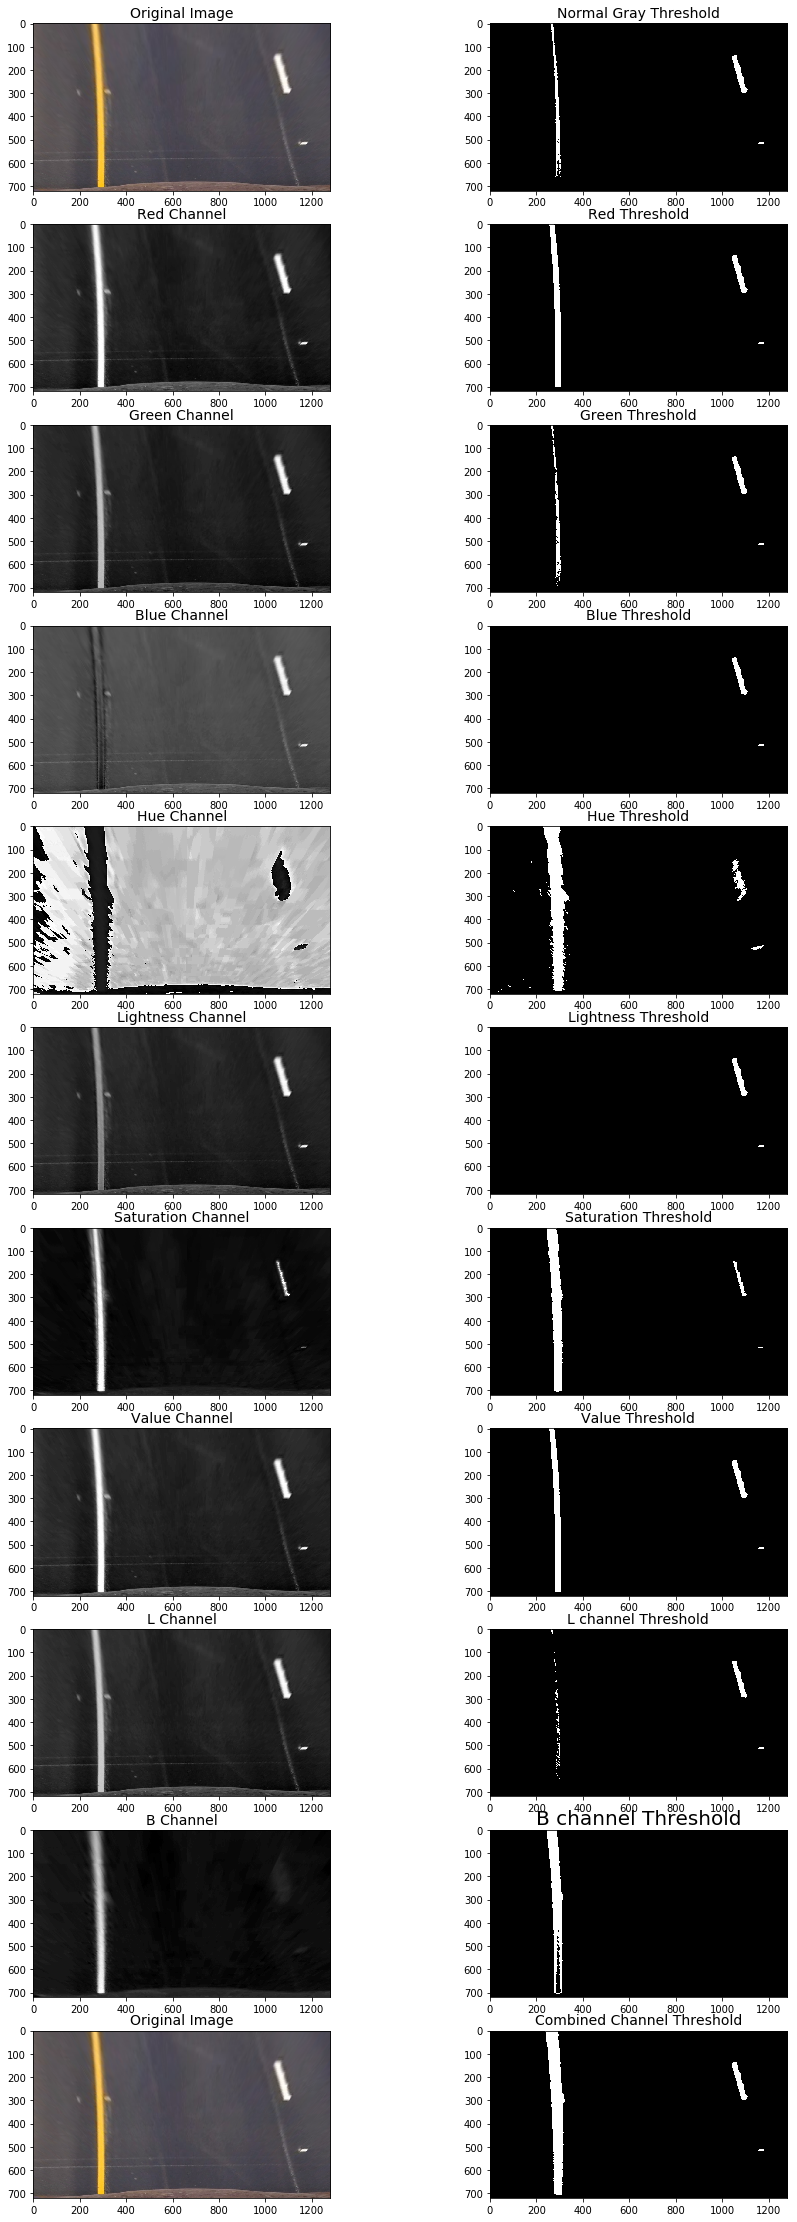

In [505]:
fig=plt.figure(figsize=(15, 40))

x = fig.add_subplot(11,2,1)
x.set_title('Original Image',size=14)
x.imshow(warped)


y = fig.add_subplot(11,2,2)
y.set_title('Normal Gray Threshold',size=14)
y.imshow(color_thresh(cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY),(200,255)),cmap='gray')

red = seperate_color_channel(warped,'r')
r = fig.add_subplot(11,2,3)
r.set_title('Red Channel',size=14)
r.imshow(red, cmap='gray')


rt = fig.add_subplot(11,2,4)
rt.set_title('Red Threshold',size=14)
rt.imshow(color_thresh(red,(200,255)),cmap='gray')

green = seperate_color_channel(warped,'g')
g = fig.add_subplot(11,2,5)
g.set_title('Green Channel',size=14)
g.imshow(green, cmap='gray')

gt = fig.add_subplot(11,2,6)
gt.set_title('Green Threshold',size=14)
gt.imshow(color_thresh(green,(200,255)),cmap='gray')

blue = seperate_color_channel(warped,'b')
b = fig.add_subplot(11,2,7)
b.set_title('Blue Channel',size=14)
b.imshow(blue, cmap='gray')

bt = fig.add_subplot(11,2,8)
bt.set_title('Blue Threshold',size=14)
bt.imshow(color_thresh(blue,(200,255)),cmap='gray')

hue = seperate_hls_color_channel(warped,'h')
h = fig.add_subplot(11,2,9)
h.set_title('Hue Channel',size=14)
h.imshow(hue, cmap='gray')

ht = fig.add_subplot(11,2,10)
ht.set_title('Hue Threshold',size=14)
ht.imshow(color_thresh(hue,(15,100)),cmap='gray')

lightness = seperate_hls_color_channel(warped,'l')
l = fig.add_subplot(11,2,11)
l.set_title('Lightness Channel',size=14)
l.imshow(lightness, cmap='gray')

lt = fig.add_subplot(11,2,12)
lt.set_title('Lightness Threshold',size=14)
lt.imshow(color_thresh(lightness,(200,255)),cmap='gray')


saturation = seperate_hls_color_channel(warped,'s')
s = fig.add_subplot(11,2,13)
s.set_title('Saturation Channel',size=14)
s.imshow(saturation, cmap='gray')

st = fig.add_subplot(11,2,14)
st.set_title('Saturation Threshold',size=14)
st.imshow(color_thresh(saturation,(90,255)),cmap='gray')

value = seperate_hsv_color_channel(warped,'v')
v = fig.add_subplot(11,2,15)
v.set_title('Value Channel',size=14)
v.imshow(value, cmap='gray')

vt = fig.add_subplot(11,2,16)
vt.set_title('Value Threshold',size=14)
vt.imshow(color_thresh(value,(200,255)),cmap='gray')

l_channel = seperate_luv_color_channel(warped,'l')
l = fig.add_subplot(11,2,17)
l.set_title('L Channel',size=14)
l.imshow(l_channel, cmap='gray')

lt = fig.add_subplot(11,2,18)
lt.set_title('L channel Threshold',size=14)
lt.imshow(color_thresh(l_channel,(215,255)),cmap='gray')

b_channel = seperate_lab_color_channel(warped,'b')
b = fig.add_subplot(11,2,19)
b.set_title('B Channel',size=14)
b.imshow(b_channel, cmap='gray')

bt = fig.add_subplot(11,2,20)
bt.set_title('B channel Threshold',size=20)
bt.imshow(color_thresh(b_channel,(155,200)),cmap='gray')


x2 = fig.add_subplot(11,2,21)
x2.set_title('Original Image',size=14)
x2.imshow(warped)

combine = combine_thresh(warped)
cmb = fig.add_subplot(11,2,22)
cmb.set_title('Combined Channel Threshold',size=14)
cmb.imshow(combine,cmap='gray')




plt.show()
fig.savefig("reference_images/test-seperate-color-channel")  


After testing various color channels and thresholds, the following did a good job in identifying the lane lines in the warped images.

1. The R channel from the RGB color space, with a min threshold of 200 and a max threshold of 255.It managed to identify both the white and yellow lane line.
2. The S channel from HLS color space, with a min threshold of 90 and max threshold of 255 managed to also identify both the white and yellow lane lines.
3. The L channel from the LUV color space, with a min threshold of 215 and a max threshold of 255 did a good job in picking out the white lane line, however it performed poorly when it came to picking out the yellow lane line.
4. The B channel from the LAB color space, with a min threshold of 155  and a max threshold of 200 , managed to identify the yellow lane line but ignored the white lane line.

I inturn created a combined binary threshold based on the above four mentioned binary thresholds, in order to create a combination thresholded image which is able to pick out both the white and yellow lane lines. 


### Step - 5 Finding Lane Lines
The combined binary image, which is the output of the prvious step of the pipeline helps isolate only those pixels which belong to the lane lines. This step in turn focuses on fitting a polynomial to each lane line by carrying out the methods.


#### Method - 1 Line Finding Method: Peaks in a Histogram & Window Search

1. First step involves identifying peaks in the histogram of the image, in order to determine the location of the lane lines.
2. Next step is to use the function ```numpy.nonzero()``` to identify all the non-zero pixels around the histogram peaks.
3. Final step invloves fitting a polynominal to each of the lanes by using the function ```numpy.ployfit()```.

In [514]:
def window_slide_fit_line_hist(img=None,nwindows = 9,do_window_search=True,left_fit=None,right_fit=None,show_img=False):
    histogram = np.sum(img[img.shape[0]//2:,:],axis=0)
    fig = None
    
    if show_img:
        fig=plt.figure(figsize=(12, 12))
        hst = fig.add_subplot(2,1,1)
        hst.set_title("Histogram")
        hst.plot(histogram)
        
    out_img = np.dstack((img,img,img))*255
        
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    if do_window_search:
        window_height =np.int(img.shape[0]/nwindows)
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
  
    # Set the width of the windows +/- margin
    margin = 100
    
    if not do_window_search and left_fit is not None and right_fit is not None:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    if do_window_search:
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
     
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if show_img:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        result_plot = fig.add_subplot(2,1,2)
        result_plot.imshow(result)
        result_plot.plot(left_fitx, ploty, color='yellow')
        result_plot.plot(right_fitx, ploty, color='yellow')
        result_plot.set_xlim([0, 1280])
        result_plot.set_ylim([720, 0])
        result_plot.set_title("Window Slide Find Lane Line")
    if show_img:
        fig.savefig("reference_images/finding_lane_lines")
        output_img = cvt_fig_to_img(fig)
        return left_fit,right_fit,leftx,rightx,lefty,righty,output_img
    else:
        return left_fit,right_fit,leftx,rightx,lefty,righty
    
            

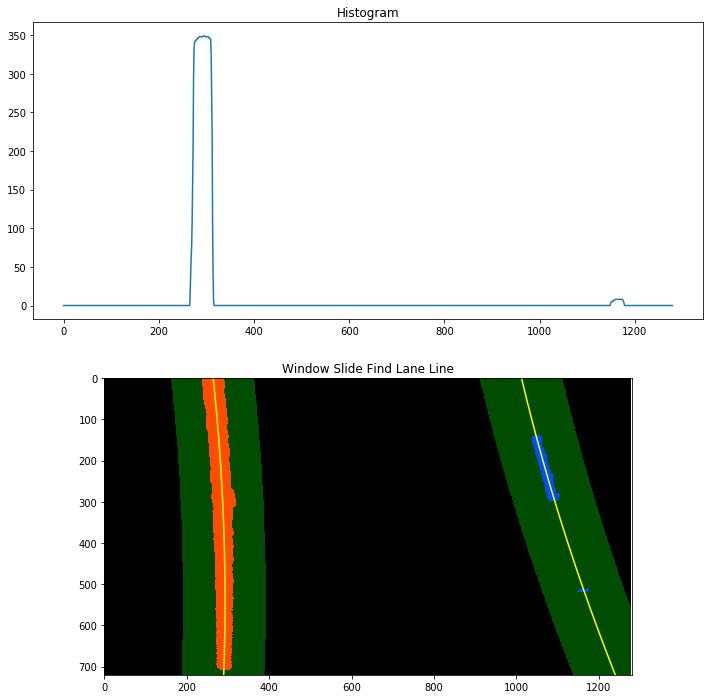

In [515]:
left_fit,right_fit,leftx,rightx,lefty,righty,output_img = window_slide_fit_line_hist(img=combine,
                           nwindows = 9,
                           do_window_search=True,
                           left_fit=None,
                           right_fit=None,
                           show_img=True)

#### Method - 2 Finding Lane Lines Using  Convolution & Window Search

In [471]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def window_slide_fit_line_conv(img=None, window_width=50, window_height=80, margin=100,show_image=False):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(img[int(3*img.shape[0]/4):,:int(img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(img[int(3*img.shape[0]/4):,int(img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(img.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(img.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[int(img.shape[0]-(level+1)*window_height):int(img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,img.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
   
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

            # Draw the results
            template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
            image = np.array(cv2.merge((img,img,img)),np.uint8) # making the original road pixels 3 color channels
            output = cv2.addWeighted(image, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img,img,img)),np.uint8)
    if show_image:
        # Display the final results
        plt.imshow(output)
        plt.title('window fitting results')
        plt.show()
    return window_centroids

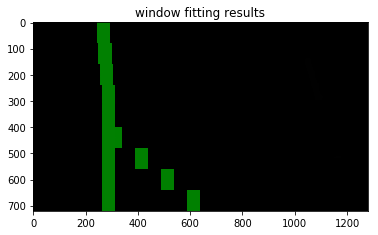

In [473]:
centroids = window_slide_fit_line_conv(combine,show_image=True)

### Measure Curvature

The following function is used to calculate the radius of curvature for each lane in meters, and the final radius of curvature that is returned as an output is an average of the left and right curve radius.

In [485]:
def measure_curvature(left_fit,right_fit,leftx,rightx,lefty,righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    #Measure Curvature in pixels
    left_curverad_px = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad_px = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    return left_curverad_m,right_curverad_m,int((left_curverad_m + right_curverad_m)/2)


In [491]:
left_curverad_m,right_curverad_m,curvature = measure_curvature(left_fit,right_fit,leftx,rightx,lefty,righty)

### Measure Position of the Vehicle from the Center

Once the polynomial was fit to each of the lane line, the position of the vehicle with respect to the center was computed using the following calculations.

- Calculated the average of the x intercepts from each of the two polynomials, ```position =(rightx_int + leftx_int)/2```
- Calculated the distance of the vehicle from center by taking the absolute value of the vehicle position minus the halfway point along the horizontal axis ```distance_from_center = abs(image_width/2 - position)```
- If the horizontal position of the car was greater than ```image_width/2```, then the car was classified to be left of the center, else it was classified to be on the right of the center.
- The finally step of the computation involves converting the distance from the center from pixels to meters by multiplying the number of pixels by ```3.7/700```

In [488]:
def center_of_vehicle(left_fit,right_fit):
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    return center

In [489]:
center = center_of_vehicle(left_fit,right_fit)

### Step - 6 Draw Lane Lines

The final step of the pipeline involves plotting the polynomials on to the warped image and then fill the space between the polynomials to highlight the lane in which the vehicle is in.Then use another perspective transformation to unwarp the image from the bird's-eye view perspective and also display in text on the top fold of the image, the position of the vehicle from the center and the average radius of curvature of the lane lines.

The function below accomplishes this exactly.

In [479]:
def draw(image,combined_binary,undist,Minv,left_fit,right_fit,center,curvature):
    
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    """
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    """
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    #cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (34,255, 34))
                 
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    if center < 640:
        text1 = 'Vehicle is {:.2f}m left of center'.format(center*3.7/700)
    else:
        text1 = 'Vehicle is {:.2f}m right of center'.format(center*3.7/700)
    text2 = 'Radius of curvature is {}m'.format(curvature)
    result = cv2.putText(result,text1, (150,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),6)
    result = cv2.putText(result,text2, (150,180), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),6)
    
    return result

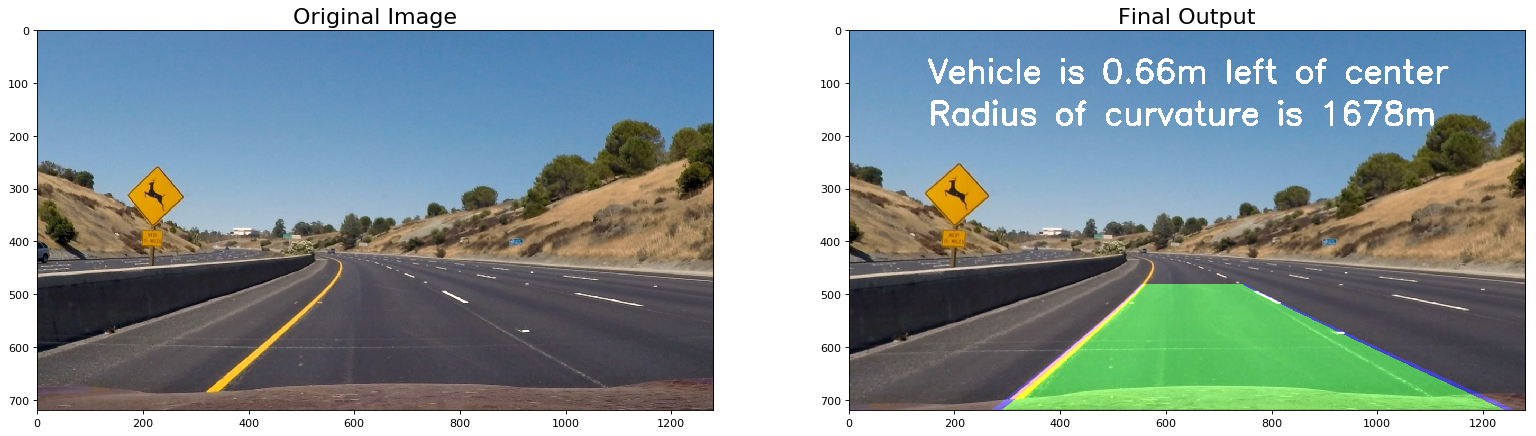

In [492]:
final_result = draw(image,combine,undist,Minv,left_fit,right_fit,center,curvature)
show_save_before_after(image,final_result,"Original Image","Final Output","reference_images/final_output")

### Advanced Lane Line Detector and Line Class

As the goal of the project was to process each frame of the video and to create as smooth and robust output of the detected lane lines. Therefore, I created  a class called ```Line```  and instantiated it for both the ```Right``` and ```Left``` lane lines. 

The Line class in turn stores features of each of the lanes, so that their corresponding values can be averaged across every the frame. 

The ```Pipeline``` function in the ```AdvanceLaneLineDetector``` class first checks whether or not the lane was detected in the previous frame. If the lane was detected in the previous frame, it in turn checks for lane pixels in close proximity to the polynomial calculated in the prvious frame. This in turn makes the pipeline more efficient as it does not need to scan the entire image again, and the pixels which were detected have a high probability of belonging to the lane line, as it was based on the location of the pixel locaion of the lane in the previous frame.

If however, the pipeline fails to detect the lane line in a current frame, based on the previous frame, only then will it perform a ```blind_search```, where it scans the entire binary image for non-zero pixels in order to represent the lane lines.

In order to achieve the goal of producing a smooth output, the coefficients of the polynomials for each of the lane line, were averaged over a span of 10 frames.


In [519]:
class Line:
    def __init__(self):
        # Was the lineprevious frame found found in the 
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

class AdvanceLaneLineDetector():
    
    def __init__(self):
        self.calibration_folder = CAMERA_CALIBRATION_IMAGES_FOLDER
        self.objpoints,self.imgpoints = calibrate_camera(self.calibration_folder,show_image=False)
        Left = Line()
        Right = Line()
        
    def pipeline(self,image,display_steps=False):
        steps = []
        img_size = (image.shape[1], image.shape[0])
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(self.objpoints,
                                                       self.imgpoints,
                                                       img_size,
                                                       None,
                                                       None)
        undist = undistort_image(image,mtx,dist)
        if display_steps:
            steps.append(np.copy(undist))
        
        warped,Minv  =  perspective_transform(undist)
        if display_steps:
            steps.append(np.copy(warped))
            
        combined_binary = combine_thresh(warped)
        if display_steps:
            steps.append(np.copy(combined_binary))
        
        
        # Identify all non zero pixels in the image
        x, y = np.nonzero(np.transpose(combined_binary)) 

        if Left.found == True: # Search for left lane pixels around previous polynomial
            leftx, lefty, Left.found = Left.found_search(x, y)

        if Right.found == True: # Search for right lane pixels around previous polynomial
            rightx, righty, Right.found = Right.found_search(x, y)


        if Right.found == False: # Perform blind search for right lane lines
            rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)

        if Left.found == False:# Perform blind search for left lane lines
            leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

        lefty = np.array(lefty).astype(np.float32)
        leftx = np.array(leftx).astype(np.float32)
        righty = np.array(righty).astype(np.float32)
        rightx = np.array(rightx).astype(np.float32)

        # Calculate left polynomial fit based on detected pixels
        left_fit = np.polyfit(lefty, leftx, 2)

        # Calculate intercepts to extend the polynomial to the top and bottom of warped image
        leftx_int, left_top = Left.get_intercepts(left_fit)

        # Average intercepts across n frames
        Left.x_int.append(leftx_int)
        Left.top.append(left_top)
        leftx_int = np.mean(Left.x_int)
        left_top = np.mean(Left.top)
        Left.lastx_int = leftx_int
        Left.last_top = left_top

        # Add averaged intercepts to current x and y vals
        leftx = np.append(leftx, leftx_int)
        lefty = np.append(lefty, 720)
        leftx = np.append(leftx, left_top)
        lefty = np.append(lefty, 0)

        # Sort detected pixels based on the yvals
        leftx, lefty = Left.sort_vals(leftx, lefty)

        Left.X = leftx
        Left.Y = lefty

        # Recalculate polynomial with intercepts and average across n frames
        left_fit = np.polyfit(lefty, leftx, 2)
        Left.fit0.append(left_fit[0])
        Left.fit1.append(left_fit[1])
        Left.fit2.append(left_fit[2])
        left_fit = [np.mean(Left.fit0), 
                    np.mean(Left.fit1), 
                    np.mean(Left.fit2)]

        # Fit polynomial to detected pixels
        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
        Left.fitx = left_fitx

        # Calculate right polynomial fit based on detected pixels
        right_fit = np.polyfit(righty, rightx, 2)

        # Calculate intercepts to extend the polynomial to the top and bottom of warped image
        rightx_int, right_top = Right.get_intercepts(right_fit)

        # Average intercepts across 5 frames
        Right.x_int.append(rightx_int)
        rightx_int = np.mean(Right.x_int)
        Right.top.append(right_top)
        right_top = np.mean(Right.top)
        Right.lastx_int = rightx_int
        Right.last_top = right_top
        rightx = np.append(rightx, rightx_int)
        righty = np.append(righty, 720)
        rightx = np.append(rightx, right_top)
        righty = np.append(righty, 0)

        # Sort right lane pixels
        rightx, righty = Right.sort_vals(rightx, righty)
        Right.X = rightx
        Right.Y = righty

        # Recalculate polynomial with intercepts and average across n frames
        right_fit = np.polyfit(righty, rightx, 2)
        Right.fit0.append(right_fit[0])
        Right.fit1.append(right_fit[1])
        Right.fit2.append(right_fit[2])
        right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]

        # Fit polynomial to detected pixels
        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
        Right.fitx = right_fitx

        # Compute radius of curvature for each lane in meters
        left_curverad,right_curverad,curvature = measure_curvature(left_fit,right_fit,leftx,rightx,lefty,righty)
        # Only print the radius of curvature every 3 frames for improved readability
        if Left.count % 3 == 0:
            Left.radius = left_curverad
            Right.radius = right_curverad

        Left.count += 1

        #Find the distance from the center
        center= center_of_vehicle(left_fit,right_fit)
        
        #Draw the lane lines
        output_img = draw(image,combined_binary,undist,Minv,left_fit,right_fit,center,curvature)
        
        if display_steps:
            left_fit,right_fit,leftx,rightx,lefty,righty,find_lane_line_img = window_slide_fit_line_hist(combined_binary,9,False,left_fit,right_fit,True)
            steps.append(find_lane_line_img)
        
        if display_steps:
            steps.append(np.copy(output_img))
            return steps
        
        return output_img
      

In [520]:
alld = AdvanceLaneLineDetector()

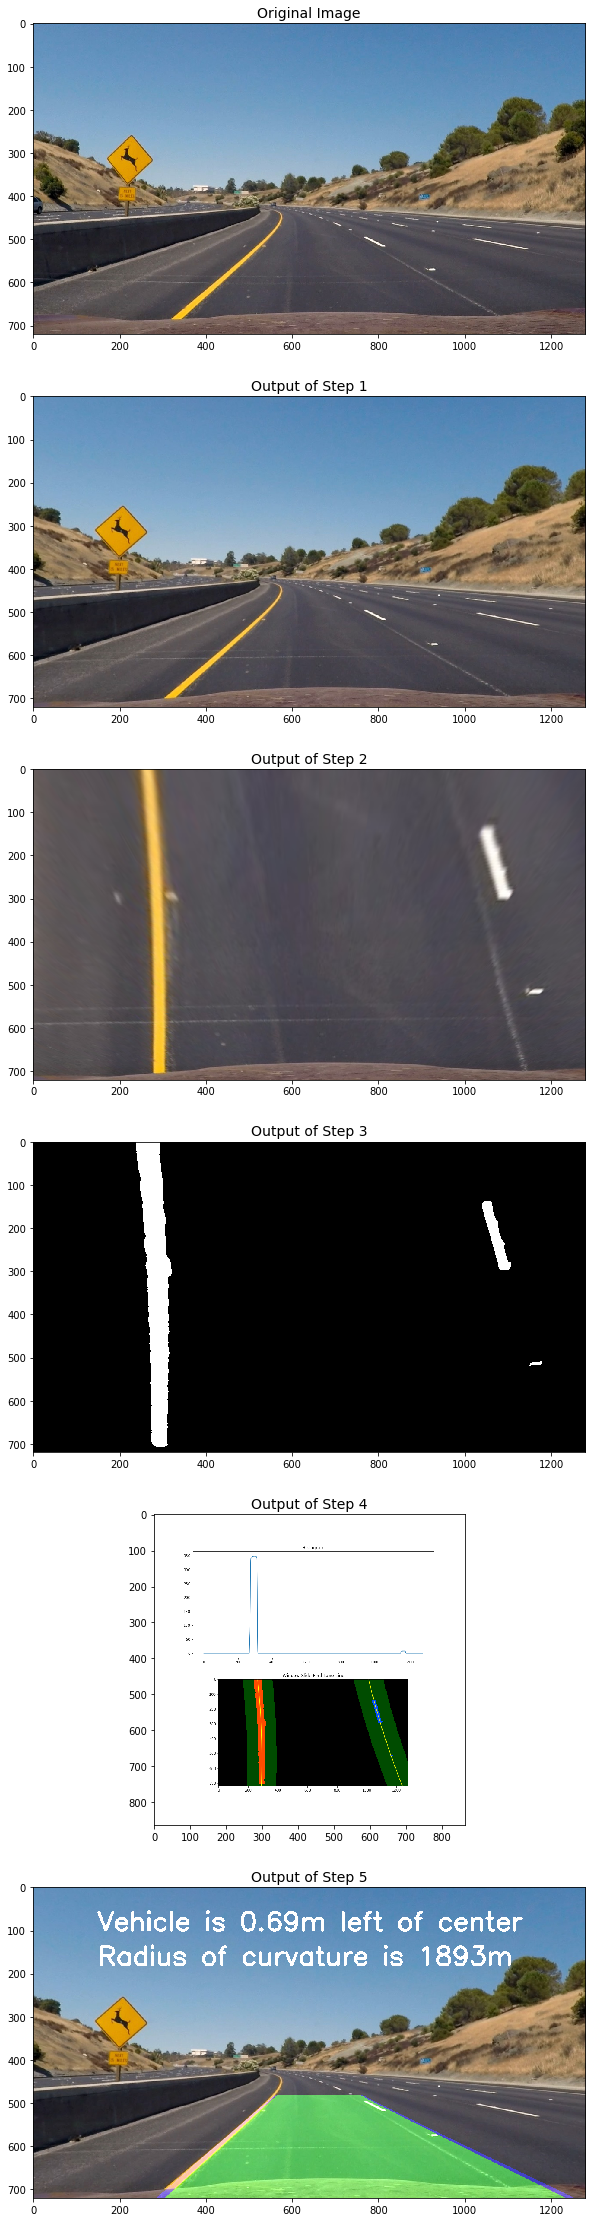

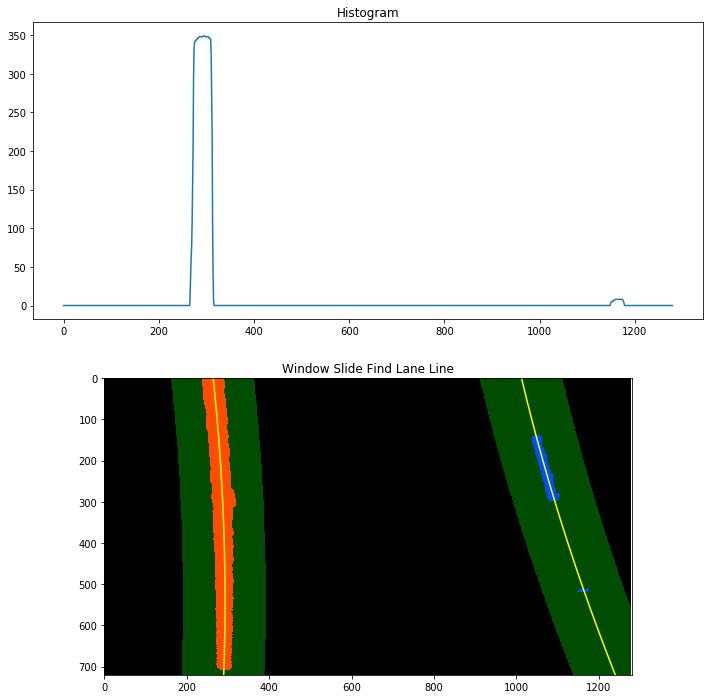

In [521]:
fig=plt.figure(figsize=(15, 40))
img = mpimg.imread('test_images/test2.jpg')
num_of_imgs = 1
returned_imgs = alld.pipeline(img,True)
steps = len(returned_imgs) + 1
count = 1

x = fig.add_subplot(steps,num_of_imgs,count)
x.set_title('Original Image',size=14)
x.imshow(img)
count +=1

for ret_img in returned_imgs:
    z = fig.add_subplot(steps,num_of_imgs,count)
    z.set_title('Output of Step {}'.format(count-1),size=14)
    if count  == 3 or count == 4:
        z.imshow(ret_img,cmap='gray')
    else:
        z.imshow(ret_img)
    count+=1

fig.savefig("reference_images/pipeline_step_by_step")  
plt.show()


### Process and Output Project Video

After designing the pipeline to process still images, the next step involved processing the video frame by frame as it would be like to process an image stream in real time on an actual self driving car.

In [506]:
def process_video(video_input,video_output):
    """
    This function help process the video through the pipeline frame by frame  and
    finally saves the the output video to a specified file.
    """
    detector = AdvanceLaneLineDetector()
    clip = VideoFileClip(video_input)
    processed = clip.fl_image(detector.pipeline)
    %time processed.write_videofile(video_output, audio=False)

In [478]:
PROJ_VID_INPUT = "test_videos/project_video.mp4"
PROJ_VID_OUTPUT = "test_videos_output/project_video.mp4"
process_video(PROJ_VID_INPUT,PROJ_VID_OUTPUT)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [15:40<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 17min 23s, sys: 22 s, total: 17min 45s
Wall time: 15min 40s


In [480]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(PROJ_VID_OUTPUT))

### Process and Output Challenge Video

In [463]:
CHALLENGE_VID_INPUT = "test_videos/challenge_video.mp4"
CHALLENGE_VID_OUTPUT = "test_videos_output/challenge_video.mp4"
process_video(CHALLENGE_VID_INPUT,CHALLENGE_VID_OUTPUT)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<05:59,  1.35it/s]

  0%|          | 2/485 [00:01<05:53,  1.36it/s]

  1%|          | 3/485 [00:02<05:56,  1.35it/s]

  1%|          | 4/485 [00:02<05:56,  1.35it/s]

  1%|          | 5/485 [00:03<05:56,  1.35it/s]

  1%|          | 6/485 [00:04<05:54,  1.35it/s]

 32%|███▏      | 155/485 [01:49<03:50,  1.43it/s]


 64%|██████▎   | 309/485 [03:40<02:10,  1.35it/s]


 95%|█████████▌| 463/485 [05:34<00:16,  1.35it/s]


100%|██████████| 485/485 [05:50<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 6min 31s, sys: 8.3 s, total: 6min 39s
Wall time: 5min 51s


In [464]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(CHALLENGE_VID_OUTPUT))

### Conclusion

The pipeline developed did a robust job in detecting the lane lines distinctly in the video, in ideal road quality, lighting and whether conditions. The pipeline also did a fairly good job on the challenge video provided, with the exception of losing the lane lines momentarily due to the shadow that occured when the car drove under the overpass. 

However, there are limitations to the pipeline, especially when the conditions are not ideal, such as a sharp turns, poor raod quality, cloudy or heavy rain weather conditions and when the lighting conditions are very bright. The challenging aspect is to find a certain set of image processing steps in the pipeline with fintuned parameters to work well in all conditions. 

The pipeline may need to be dynamic in order to work well in any condition and this something that can be further looked into, in order to be able to identify the lane lines more robustly.

Video recordings of driving a car in different conditions can also be made in order to further test and improve the pipeline for detecting the lane lines more robustly. 